<a href="https://colab.research.google.com/github/Jojocko/NLP-projects-/blob/main/Supply_chain_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets NLP/dataset_supplychain.csv')

Mounted at /content/drive


In [2]:
df = df.drop(['client', 'langage', 'reponse'], axis=1)
df.rename(columns={'Sentiment': 'sentiment', 'Commentaire': 'commentaire'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'__label__POSITIVE': 'positif', '__label__NEGATIVE': 'negatif', '__label__NEUTRAL': 'neutre'})
df['date'] = df['date'].fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year # pour une visualisation de l'évolution chronologique plus claire

In [3]:
df_paires = pd.read_csv('/content/drive/My Drive/Datasets NLP/paires_commentaires.csv')

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('french'))

jugement = {'très', 'extrêmement', 'particulièrement', 'exceptionnellement','tout à fait', 'absolument', 'complètement', 'entièrement', 'parfaitement', 'profondément', 'hautement', 'tout', 'plutôt', 'assez', 'bien', 'bon','vraiment', 'totalement', 'énormément', 'peu', 'moins'}
satisfaction = {'satisfait', 'content', 'heureux', 'ravi', 'enchanté', 'comblé', 'agréable', 'plaisant', 'positif', 'excellent', 'remarquable', 'exceptionnel', 'superbe', 'admirable', 'réjoui', 'gratifiant', 'récompensant', 'conquis', 'impressionné', 'élogieux'}
insatisfaction = {'insatisfait', 'mécontent', 'déçu', 'frustré', 'contrarié', 'désappointé', 'inacceptable', 'problématique', 'inadmissible', 'déplorable', 'lamentable', 'irrité', 'en colère', 'révolté', 'amère', 'négatif', 'critique', 'malheureux', 'peu convaincu', 'regrettable'}
company = {'Fnac', 'fnac', 'Amazon', 'amazon', 'CDiscount', 'cdiscount'}

stop_words.update(jugement, satisfaction, insatisfaction, company)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Traitement des données

import re
import unicodedata
from nltk.tokenize import word_tokenize

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df.cleaned_lemma = df.cleaned_lemma.apply(lambda x :preprocess_sentence(x))

In [6]:
# Prétraitement et lemmatisation pour df_paires > pas de préprocessing avec transformers?

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def lemmatisation(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_and_lemmatize(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = re.sub(r'\b\w{0,2}\b', '', sentence)

    mots = word_tokenize(sentence.strip())
    mots_tagged = pos_tag(mots)

    lemmatizer = WordNetLemmatizer()
    mots_lemmatises = [lemmatizer.lemmatize(mot, lemmatisation(tag)) for mot, tag in mots_tagged]
    mots_lemmatises = [mot for mot in mots_lemmatises if mot not in stop_words]

    return ' '.join(mots_lemmatises).strip()

df_paires['Commentaire A'] = df_paires['Commentaire A'].apply(preprocess_and_lemmatize)
df_paires['Commentaire B'] = df_paires['Commentaire B'].apply(preprocess_and_lemmatize)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Finetuning du transformer

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

paires = [InputExample(texts=[row['Commentaire A'], row['Commentaire B']], label=float(row['Distance sémantique'])) for index, row in df_paires.iterrows()]

train_set = DataLoader(paires, shuffle=True, batch_size=200)

train_loss = losses.CosineSimilarityLoss(model=model)

model.fit(train_objectives=[(train_set, train_loss)], epochs=10, warmup_steps=100)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# Clustering, utiliser .transform pour donner une idée de la proximité de chaque commentaire par rapport à chaque cluster.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

embeddings_negatif = model.encode(df[df['sentiment'] == 'negatif']['cleaned_lemma'].tolist(), show_progress_bar=True)

# normalisation
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_negatif)

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(embeddings_scaled)

# distances aux centres de clusters
distances = kmeans.transform(embeddings_scaled)

# seuil pour l'association à un cluster
seuil = np.percentile(distances, 20)  # seuil aux 20% plus proches

# Association multiple en fonction du seuil
associations = distances < seuil # = tableau d'associations


Batches:   0%|          | 0/868 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
# Pour chaque commentaire, afficher les indices des clusters associés

for i, commentaire in enumerate(df[df['sentiment'] == 'negatif']['cleaned_lemma']):
    clusters_associes = np.where(associations[i])[0]
    print(f"Commentaire {i+1}: Clusters {list(clusters_associes)}")


Streaming output truncated to the last 5000 lines.
Commentaire 22748: Clusters [4, 9, 10, 12, 15]
Commentaire 22749: Clusters []
Commentaire 22750: Clusters [1, 3, 4, 5, 7, 10, 14]
Commentaire 22751: Clusters [1, 3, 9, 10, 11, 12, 13, 15, 17]
Commentaire 22752: Clusters [1, 3, 4, 5, 6, 7, 9, 10, 11, 14, 17, 18, 19]
Commentaire 22753: Clusters [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 17, 18, 19]
Commentaire 22754: Clusters [1, 3, 4, 7, 10, 11, 12, 15, 17, 18]
Commentaire 22755: Clusters []
Commentaire 22756: Clusters []
Commentaire 22757: Clusters [1, 3, 6, 7, 8, 10, 11, 17]
Commentaire 22758: Clusters [1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]
Commentaire 22759: Clusters [1, 4, 10]
Commentaire 22760: Clusters [11, 12, 15]
Commentaire 22761: Clusters [1, 7]
Commentaire 22762: Clusters []
Commentaire 22763: Clusters [1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]
Commentaire 22764: Clusters [3, 9, 10, 11, 12, 13, 14, 17]
Commentaire 22765: Clusters [4, 10, 11, 12

In [35]:
# Afficher 10 commentaires pour chaque cluster pour identifier les thématiques

df_negatif = df[df['sentiment'] == 'negatif'].reset_index(drop=True)
commentaires_negatifs = df_negatif['cleaned_lemma'].tolist()

# collecte des commentaires pour chaque cluster
commentaires_par_cluster = {i: [] for i in range(20)}

for i, commentaire in enumerate(commentaires_negatifs):
    clusters_associes = np.where(associations[i])[0]
    for cluster in clusters_associes:
        commentaires_par_cluster[cluster].append(commentaire)

for cluster, commentaires in commentaires_par_cluster.items():
    print(f"Cluster {cluster}:")
    for commentaire in commentaires[:10]:
        print(commentaire)
    print("---------\n")

Cluster 0:
recevoir produit vouloir rembourser commande pourtant colis domicile contacter vendeur vouloir rien savoir . . . fois coup coup rembourser expedier vendre . . . mois attendre remboursement eligible garantie vendeur colis etre envoyer preuve valable contacter transporteur chronopost resoudre probleme semaine dire enquete aucun reponse assoir argent colis . . . honte
abonnement prime moitie livraison retard . aujourd attendre livraison garantie arriver appeler renvoi renvoi rappeler garantir livraison lendemain contacter heure impossible livrer lendemain rererapelle demander remboursement accorder foi reserve envoler suite enervement engendrer parcours combattant aucun compensation commercial proposer dernier abonnement prime
payer precque balle jeu niece fin janvier commande expedier dire probleme recevoir remboursement sommer aujourd hui fevrier aucun remboursement deconseiller fortement site vole cacahuete
bonjour commander article corresponder desirer jai mois remboursemen

In [38]:
# attitrer les clusters et afficher les thématisations

themes = {
    0: 'Problèmes de remboursements',
    1: "État des produits à la livraison",
    2: 'État de la livraison inconnue',
    3: 'Problèmes de retours',
    4: 'Commandes perdues ou annulées',
    5: 'Abonnements Prime contestés',
    6: 'Sécurité des comptes et fraudes',
    7: 'Problèmes de livraison',
    8: 'Problèmes de qualité',
    9: 'Falsifications de livraison',
    10: 'Disparition de colis',
    11: 'Gestion des retours défaillante',
    12: 'Accusations d\'escroquerie',
    13: 'Expérience d\'achat négative',
    14: 'Délais de livraison non-respectés',
    15: 'Sécurité des paiements',
    16: 'Problèmes de double prélèvement',
    17: 'Problèmes techniques',
    18: 'Réclamations ignorées',
    19: 'Arnaques'
}
for i, commentaire in enumerate(df[df['sentiment'] == 'negatif']['cleaned_lemma']):
    clusters_associes = np.where(associations[i])[0]
    print(f"Commentaire {i+1}: Clusters {[themes[cluster] for cluster in clusters_associes]}")


Streaming output truncated to the last 5000 lines.
Commentaire 22748: Clusters ['Commandes perdues ou annulées', 'Falsifications de livraison', 'Disparition de colis', "Accusations d'escroquerie", 'Sécurité des paiements']
Commentaire 22749: Clusters []
Commentaire 22750: Clusters ['État des produits à la livraison', 'Problèmes de retours', 'Commandes perdues ou annulées', 'Abonnements Prime contestés', 'Problèmes de livraison', 'Disparition de colis', 'Délais de livraison non-respectés']
Commentaire 22751: Clusters ['État des produits à la livraison', 'Problèmes de retours', 'Falsifications de livraison', 'Disparition de colis', 'Gestion des retours défaillante', "Accusations d'escroquerie", "Expérience d'achat négative", 'Sécurité des paiements', 'Problèmes techniques']
Commentaire 22752: Clusters ['État des produits à la livraison', 'Problèmes de retours', 'Commandes perdues ou annulées', 'Abonnements Prime contestés', 'Sécurité des comptes et fraudes', 'Problèmes de livraison', 'Fa

In [42]:
# Compter le nombre de fois que les clusters sont associés à un comm

count_clusters = {cluster: 0 for cluster in themes.keys()}

for i, commentaire in enumerate(df[df['sentiment'] == 'negatif']['cleaned_lemma']):
    clusters_associes = np.where(associations[i])[0]
    for cluster in clusters_associes:
        count_clusters[cluster] += 1

sorted_clusters = sorted(count_clusters.items(), key=lambda item: item[1], reverse=True)

for cluster, compte in sorted_clusters:
    print(f"Cluster {cluster} ('{themes[cluster]}'): {compte} fois")



Cluster 10 ('Disparition de colis'): 10897 fois
Cluster 1 ('État des produits à la livraison'): 8758 fois
Cluster 3 ('Problèmes de retours'): 8725 fois
Cluster 7 ('Problèmes de livraison'): 8685 fois
Cluster 9 ('Falsifications de livraison'): 8659 fois
Cluster 11 ('Gestion des retours défaillante'): 8460 fois
Cluster 4 ('Commandes perdues ou annulées'): 8244 fois
Cluster 12 ('Accusations d'escroquerie'): 5877 fois
Cluster 14 ('Délais de livraison non-respectés'): 5524 fois
Cluster 15 ('Sécurité des paiements'): 5366 fois
Cluster 17 ('Problèmes techniques'): 5365 fois
Cluster 13 ('Expérience d'achat négative'): 5155 fois
Cluster 19 ('Arnaques'): 5038 fois
Cluster 18 ('Réclamations ignorées'): 4523 fois
Cluster 8 ('Problèmes de qualité'): 3657 fois
Cluster 6 ('Sécurité des comptes et fraudes'): 3572 fois
Cluster 5 ('Abonnements Prime contestés'): 2682 fois
Cluster 0 ('Problèmes de remboursements'): 812 fois
Cluster 16 ('Problèmes de double prélèvement'): 507 fois
Cluster 2 ('État de la l

In [56]:
# Affichage des commentaires qui sont associés à au moins 3 clusters

commentaires_3clusters = []

for i, commentaire in enumerate(df[df['sentiment'] == 'negatif']['cleaned_lemma']):
    clusters_associes = np.where(associations[i])[0]
    if len(clusters_associes) >= 3:  # Vérifier si le commentaire est associé à au moins 3 clusters
        # Ajouter le commentaire à la liste avec les clusters associés
        commentaires_3clusters.append((commentaire, clusters_associes))


# dataframe de 5 commentaires associés à au moins 3 clusters
donnees = [{
    "Commentaire": commentaire,
    "Clusters associés": ', '.join([themes[cluster] for cluster in clusters])
} for commentaire, clusters in commentaires_3clusters[:5]]  # Limiter à 5 commentaires ici

df_commentaires_3clusters = pd.DataFrame(donnees)

pd.set_option('display.max_colwidth', None)
df_commentaires_3clusters.head()

,Commentaire,Clusters associés
0,colis commander mardi fevrier livraison jeudi mars produit non recu mars prix colis incapable chronopost pareilservic client veule patient journee plusle colis introuvable chronopost renvoyer balle amazonamazon vouloir renvoyer article semaine attendre colis,"État de la livraison inconnue, Problèmes de retours, Commandes perdues ou annulées, Disparition de colis, Réclamations ignorées"
1,colis dire livrer jamais recevoir perdre non rembourser falsification livraison dire signer soin signature majuscule mdr signe jamais document majuscule moquer client resilier aboment prime finir,"Falsifications de livraison, Disparition de colis, Gestion des retours défaillante, Accusations d'escroquerie, Arnaques"
2,colis devoir livrer jour heure livraison etre reporter aucun livreur passer suivi colis impossible service client discussion ligne brouillonner laborieux interlocuteur maitriser francais multiple connexion tentative contacter service client reussir faire annuler commande verifier remboursement . . . jamais experimenter livraison abstenir commander article volumineux,"État des produits à la livraison, Problèmes de retours, Commandes perdues ou annulées, Sécurité des comptes et fraudes, Problèmes de livraison, Falsifications de livraison, Disparition de colis, Gestion des retours défaillante, Accusations d'escroquerie, Sécurité des paiements, Problèmes techniques, Réclamations ignorées, Arnaques"
3,bonjour appel service client dire souci prendre charge demande article arriver temps demander colis expedie rappeler croyez souci blablabla aujourd colis livre semaine prochain service client dire oui collegue tromper magnifique plomber incroyable dernier assistant client dire rien etre ecoute mieux aider marche tete,"Commandes perdues ou annulées, Problèmes de livraison, Falsifications de livraison, Disparition de colis, Délais de livraison non-respectés"
4,livraison catastrophique avoir notifier compte amazone colis etre livrer remettre gardien livraison lieu soir gardien recuperer colis colis disparaitre retrouver rue retrouver jardin retrouver arriver service client patienter enquete lancer impossible contacter livreur heure auparavant cense presenter dramatique recevoir colis,"État des produits à la livraison, État de la livraison inconnue, Problèmes de retours, Commandes perdues ou annulées, Problèmes de livraison, Falsifications de livraison, Disparition de colis, Gestion des retours défaillante, Délais de livraison non-respectés, Réclamations ignorées"


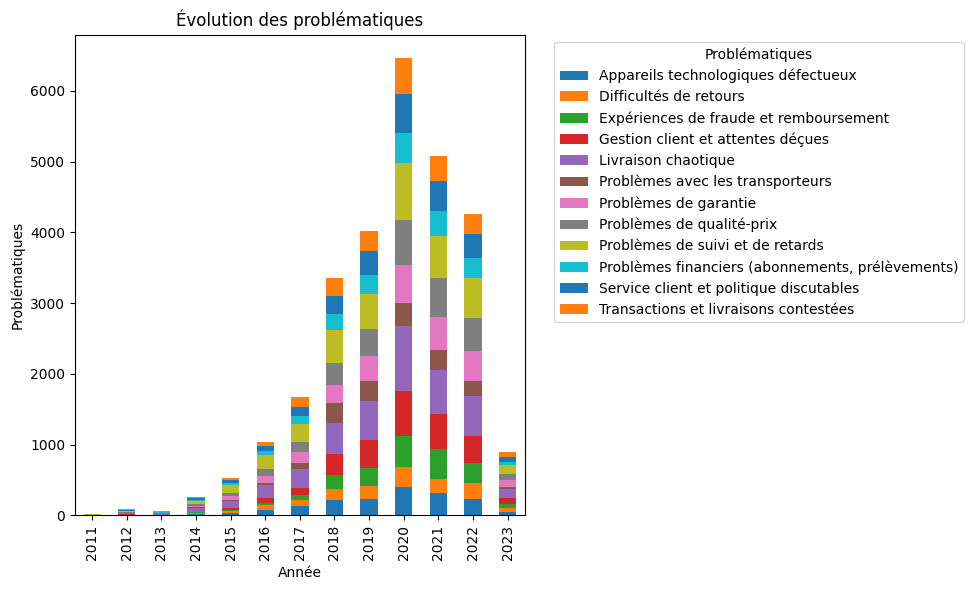

In [ ]:
# Suite à réitérer

import matplotlib.pyplot as plt

themes_evo = df_negatif.groupby(['year', 'themes']).size().unstack(fill_value=0)

themes_evo.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Évolution des problématiques')
plt.xlabel('Année')
plt.ylabel('Problématiques')
plt.legend(title='Problématiques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
themes_company = df_negatif.groupby(['company', 'themes']).size().unstack(fill_value=0)

print(themes_company)

themes     Appareils technologiques défectueux  Difficultés de retours  \
company                                                                  
Amazon                                     240                     258   
CDiscount                                  948                     770   
Fnac                                       534                     275   

themes     Expériences de fraude et remboursement  \
company                                             
Amazon                                        311   
CDiscount                                    1278   
Fnac                                          212   

themes     Gestion client et attentes déçues  Livraison chaotique  \
company                                                             
Amazon                                   672                  942   
CDiscount                               1502                 2128   
Fnac                                     324                  775   

themes     Problè